In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
from tqdm import tqdm
import tensorflow

tensorflow.random.set_seed(23)

from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras import backend
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, LeakyReLU, Concatenate,BatchNormalization,Add,ZeroPadding2D, ReLU
from tensorflow.keras import initializers, optimizers
from tensorflow.keras.models import Model
from numpy import ones, zeros
from tensorflow.keras.utils import plot_model

In [2]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

files = os.listdir('../input/landscape-image-colorization/landscape Images/color')
files = sorted_alphanumeric(files)

Enter a number between 0 and 7129:  468


468
(150, 150, 3)


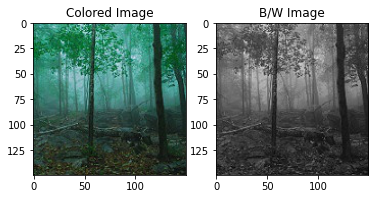

(150, 150, 3)


In [3]:
ran = int(input('Enter a number between 0 and {}: '.format(len(files))))
print(ran)
img = load_img('../input/landscape-image-colorization/landscape Images/color/'+str(ran)+'.jpg')
plt.subplot(121)
plt.imshow(img)
plt.title('Colored Image')
print(img_to_array(img).shape)

img = load_img('../input/landscape-image-colorization/landscape Images/gray/'+str(ran)+'.jpg')
plt.subplot(122)
plt.imshow(img)
plt.title('B/W Image')
plt.show()
print(img_to_array(img).shape)

In [4]:
def mirroring(img):
    return tensorflow.image.flip_left_right(img)


color_img =[]
bw_img = []

path_c = '../input/landscape-image-colorization/landscape Images/color'
path_bw = '../input/landscape-image-colorization/landscape Images/gray'

files_c = os.listdir(path_c)
files_bw = os.listdir(path_bw)

c_path = sorted_alphanumeric(files_c)
bw_path = sorted_alphanumeric(files_bw)

print('No. of colored images', str(len(files_c)))
print('No. of b/w images', str(len(files_bw)))

for i in tqdm(range(len(files_c))):
    img_c = load_img(path_c + '/'+ c_path[i], target_size=(150,150))
    img_bw = load_img(path_bw + '/'+ bw_path[i], target_size=(150,150))
    if np.random.uniform() > 0.5:
        img_c = mirroring(img_c)
        img_bw= mirroring(img_bw)
        
        img_c = (img_to_array(img_c) - 127.5)/127.5
        img_bw= (img_to_array(img_bw) - 127.5)/127.5
        
        color_img.append(img_c)
        bw_img.append(img_bw)

    else:
        img_c = (img_to_array(img_c) - 127.5)/127.5
        img_bw = (img_to_array(img_bw) - 127.5)/127.5
        color_img.append(img_c)
        bw_img.append(img_bw)
    
    
color_img = np.array(color_img).astype('float16')
bw_img = np.array(bw_img).astype('float16')

color_img.shape, bw_img.shape

No. of colored images 7129
No. of b/w images 7129


  0%|          | 0/7129 [00:00<?, ?it/s]2022-07-12 17:14:36.799686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 17:14:36.909551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 17:14:36.910658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 17:14:36.914566: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuil

((7129, 150, 150, 3), (7129, 150, 150, 3))

In [5]:
init_k = initializers.HeNormal(seed=23)
init_b = initializers.HeNormal(seed=37)
init = initializers.RandomNormal(stddev=0.02)

def generator():
    input_layer = Input((150,150,3))
    
    # Encoder Block
    d1 = Conv2D(96, (4,4), (2,2), kernel_initializer=init,
                bias_initializer=init)(input_layer)
    d1 = LeakyReLU()(d1)
    
    d2 = Conv2D(184, (4,4), (2,2), kernel_initializer=init,
                bias_initializer=init)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)
    
    d3 = Conv2D(256, (3,3), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU()(d3)
    
    d4 = Conv2D(384, (3,3), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d3)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU()(d4)
    
    d5 = Conv2D(512, (2,2), (2,2), padding='same' , kernel_initializer=init,
                bias_initializer=init)(d4)
    d5 = Dropout(0.1)(d5)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU()(d5)
    
    d6 = Conv2D(512, (2,2), (2,2), padding='same', kernel_initializer=init,
                bias_initializer=init)(d5)
    d6 = Dropout(0.2)(d6)
    d6 = BatchNormalization()(d6)
    d6 = LeakyReLU()(d6)
    d7 = Conv2D(512, (2,2), (1,1), padding='same' , kernel_initializer=init,
                bias_initializer=init)(d6)
    d7 = BatchNormalization()(d7)
    d7 = LeakyReLU()(d7)
    
    #Decoder Block
    u1 = Conv2DTranspose(512, (1,1), (1,1), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(d7)
    u1 = BatchNormalization()(u1)
    u1 = Concatenate()([u1, d6])
    u1 = ReLU()(u1)
    
    u2 = Conv2DTranspose(512, (3,3), (1,1), padding='valid',
                         kernel_initializer=init_k, bias_initializer=init_k)(u1)
    u2 = Dropout(0.1)(u2)
    u2 = BatchNormalization()(u2)
    u2 = Concatenate()([u2,d5])
    u2 = ReLU()(u2)
    
    u3 = Conv2DTranspose(384, (3,3), (1,1), padding='valid', activation='relu',
                         kernel_initializer=init_k, bias_initializer=init_k)(u2)
    u3 = Dropout(0.2)(u3)
    u3 = Conv2DTranspose(384, (3,3), (1,1), padding='valid',
                         kernel_initializer=init_k, bias_initializer=init_k)(u3)
    u3 = BatchNormalization()(u3)
    u3 = Concatenate()([u3, d4])
    u3 = ReLU()(u3)
    
    u4 = Conv2DTranspose(256, (3,3), (2,2), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(u3)
    u4 = BatchNormalization()(u4)
    u4 = Concatenate()([u4, d3])
    u4 = ReLU()(u4)
    
    u5 = Conv2DTranspose(184, (3,3), (2,2), padding='same',
                         kernel_initializer=init_k, bias_initializer=init_k)(u4)
    u5 = BatchNormalization()(u5)
    u5 = Concatenate()([u5, d2])
    u5 = ReLU()(u5)
    
    u6 = Conv2DTranspose(96, (3,3), (2,2), padding='valid', output_padding=(1,1))(u5)
    u6 = BatchNormalization()(u6)
    u6 = Concatenate()([u6, d1])
    u6 = ReLU()(u6)
    u7 = Conv2DTranspose(3, (3,3), (2,2),padding='valid',activation='tanh',
                         output_padding=(1,1))(u6)

    model = Model(inputs = input_layer, outputs=u7)
    return model

generator=generator()
print(generator.summary())
#plot_model(generator, to_file='generator.png', show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 96)   4704        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 74, 74, 96)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 36, 36, 184)  282808      leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [6]:
 def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

def discriminator():
    input_layer1 = Input((150,150,3))
    input_layer2 = Input((150,150,3))
    input_layer = Concatenate()([input_layer1, input_layer2])
    
    d1 = Conv2D(126, (4,4), (2,2),
                kernel_initializer=init,bias_initializer=init)(input_layer)
    d1 = LeakyReLU()(d1)
    
    d2 = Conv2D(256, (4,4), (2,2), padding='same', kernel_initializer=init,bias_initializer=init)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU()(d2)
    
    d3 = Conv2D(384, (4,4), (2,2), padding='same', kernel_initializer=init,bias_initializer=init)(d2)
    d3 = Dropout(0.1)(d3)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU()(d3)
    p1 = ZeroPadding2D()(d3)
    
    d4 = Conv2D(512, (4,4), (1,1), padding='same', kernel_initializer=init,bias_initializer=init)(p1)
    d4 = Dropout(0.15)(d4)
    d4 = BatchNormalization()(d4)
    d4 = LeakyReLU()(d4)
    p2 = ZeroPadding2D()(d4)
    
    d5 = Conv2D(1, (4,4), (1,1), padding='same', kernel_initializer=init,bias_initializer=init)(p2)
    d5 = BatchNormalization()(d5)
    d5 = LeakyReLU()(d5)
    
    model = Model([input_layer1, input_layer2], outputs=d5)
    opt = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss=wasserstein_loss, optimizer=opt, loss_weights=0.5)
    return model

discriminator = discriminator()
print(discriminator.summary())
#plot_model(discriminator,to_file='discriminator.png', show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 150, 150, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 74, 74, 126)  12222       concatenate_6[0][0]        

In [7]:
# calculate the effective receptive field size
def receptive_field(output_size, kernel_size, stride_size):
    return  kernel_size + stride_size*(output_size - 1) 
# k(l-1) = k + s(k(l)-1) by backtracing

rf = receptive_field(1, 4, 1)
print(rf)

rf = receptive_field(rf, 4, 1)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

rf = receptive_field(rf, 4, 2)
print(rf)

4
7
16
34
70


### PathGAN discriminator 70 x 70 effective receptive field is satisfied

In [9]:
''' loss = maximize: E(D(real)) - E(D(fake)) is same as 
    loss = minimize: E(D(fake)) - E(D(real)) '''

def generate_real_samples(trainA,trainB, n_samples, n_patch):
    idx = np.random.randint(0, len(trainA), n_samples)
    X1, X2 = trainA[idx], trainB[idx]
    # generate 'real' class labels (1)
    y = -ones((n_samples, n_patch, n_patch, 1))
    return X1, X2, y, idx

def generate_fake_samples(g_model, samples, n_patch):
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = ones((len(X), n_patch, n_patch, 1))
    return X, y



''' define the combined generator and discriminator model, for updating the generator
    by keeping the discriminator to trainable == False '''
def update_gen(g_model, d_model):
    d_model.trainable=False
    input_img = Input((150,150,3))
    gen_out = g_model(input_img)
    disc_out = d_model([input_img, gen_out])
    model = Model(input_img, [disc_out, gen_out])
    opt = optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
    model.compile(loss=[wasserstein_loss, 'mse'], optimizer=opt,
                  loss_weights=[1,150])
    return model

gen_update_model = update_gen(generator,discriminator)
print(gen_update_model.summary())
#plot_model(gen_update_model,to_file='generator_updation.png', show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 150, 150, 3)  17288755    input_5[0][0]                    
__________________________________________________________________________________________________
model_1 (Functional)            (None, 23, 23, 1)    5260867     input_5[0][0]                    
                                                                 model[1][0]                      
Total params: 22,549,622
Trainable params: 17,280,147
Non-trainable params: 5,269,475
__________________________________________________________________________________________________
None


In [10]:
def plott(data_c, data_g):
    n = np.random.randint(1000)
    pred = gen_update_model.layers[1].predict(data_g[n].reshape((1,150,150,3)))
    pred = (pred*127.5)+127.5
    pred = pred/255.
    plt.figure(figsize=(20,10))

    plt.subplot(131)
    g= (data_g[n]*127.5)+127.5
    g= g/255.
    plt.imshow(g.astype(np.float32))
    plt.title('Black/White Image')

    plt.subplot(132)
    c = (data_c[n]*127.5)+127.5
    c = c/255.
    plt.imshow(c.astype(np.float32))
    plt.title('Color Image')

    plt.subplot(133)
    plt.imshow(pred[0])
    plt.title('Predicted Image')
    plt.show()

In [11]:
def pix2pix_train(d_model, g_model, gen_update_model, trainA,trainB, n_epochs, n_batch):
    batches_per_epoch = int(len(trainA) / n_batch)
    n_patch = d_model.output_shape[1]
    disc_loss1 = []
    disc_loss2 = []
    gen_loss = []
    for i in range(n_epochs):
        A,B = trainA, trainB
        for j in tqdm(range(batches_per_epoch)):
            # select a batch of real samples
            real_g, real_c, y_real_label, idx=generate_real_samples(A, B,
                                                                 n_batch,n_patch)
            # deleting the already sampled records
            A = np.delete(A, idx, axis=0)
            B = np.delete(B, idx, axis=0)
            # generate a batch of fake samples
            fake_c, y_fake_label = generate_fake_samples(g_model, real_g, n_patch)
            for _ in range(5):
                # update discriminator for real samples, 5 times to that of generator
                d_loss_real = d_model.train_on_batch([real_g, real_c], y_real_label)
                # update discriminator for generated samples, 5 times to that of generator
            for _ in range(2):
                d_loss_generated = d_model.train_on_batch([real_g,fake_c], y_fake_label)
            # update the generator
            g_loss, _, _ =gen_update_model.train_on_batch(real_g, [y_real_label,real_c])
        disc_loss1.append(d_loss_real)
        disc_loss2.append(d_loss_generated)
        gen_loss.append(g_loss)
        print('>%d, d_loss_real[%.3f] d_loss_generated[%.3f] gen_loss[%.3f]' % (i+1,
                                            d_loss_real, d_loss_generated,g_loss))
        
        if (i+1)%6==0:
            plott(c_test, bw_test) # Plotting the results for the test set after every 5 epochs
            plt.show()
        gen_update_model.layers[1].save('gen'+ str(i+1)+ '.h5') 
        # Saving only the generator part of the gen_update_model
    return disc_loss1, disc_loss2, gen_loss

In [15]:
from sklearn.model_selection import train_test_split
bw_train, bw_test, c_train, c_test = train_test_split(bw_img, color_img,
                                                     test_size = 0.2, random_state=23)
bw_train.shape, bw_test.shape, c_train.shape, c_test.shape

((5703, 150, 150, 3),
 (1426, 150, 150, 3),
 (5703, 150, 150, 3),
 (1426, 150, 150, 3))

In [16]:
# deleting the unnecessary arrays to free up some RAM
import gc
del bw_img
gc.collect()
del color_img
gc.collect()

0

  0%|          | 0/1425 [00:00<?, ?it/s]2022-07-12 17:24:02.360618: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-12 17:24:03.517309: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
100%|██████████| 1425/1425 [10:48<00:00,  2.20it/s]


>1, d_loss_real[-0.227] d_loss_generated[0.072] gen_loss[7.390]


100%|██████████| 1425/1425 [10:48<00:00,  2.20it/s]


>2, d_loss_real[-0.286] d_loss_generated[0.087] gen_loss[8.676]


100%|██████████| 1425/1425 [11:06<00:00,  2.14it/s]


>3, d_loss_real[-0.336] d_loss_generated[0.116] gen_loss[7.697]


100%|██████████| 1425/1425 [11:01<00:00,  2.15it/s]


>4, d_loss_real[-0.383] d_loss_generated[0.143] gen_loss[4.317]


100%|██████████| 1425/1425 [11:02<00:00,  2.15it/s]


>5, d_loss_real[-0.430] d_loss_generated[0.168] gen_loss[3.499]


100%|██████████| 1425/1425 [11:01<00:00,  2.15it/s]


>6, d_loss_real[-0.477] d_loss_generated[0.194] gen_loss[2.560]


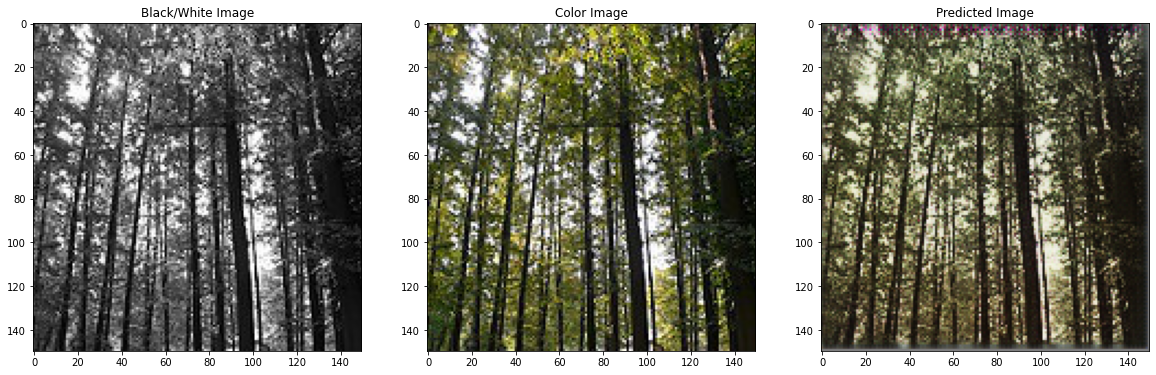

100%|██████████| 1425/1425 [10:59<00:00,  2.16it/s]


>7, d_loss_real[-0.524] d_loss_generated[0.220] gen_loss[5.940]


100%|██████████| 1425/1425 [11:00<00:00,  2.16it/s]


>8, d_loss_real[-0.570] d_loss_generated[0.245] gen_loss[4.596]


100%|██████████| 1425/1425 [11:01<00:00,  2.16it/s]


>9, d_loss_real[-0.617] d_loss_generated[0.271] gen_loss[2.280]


100%|██████████| 1425/1425 [11:01<00:00,  2.15it/s]


>10, d_loss_real[-0.664] d_loss_generated[0.296] gen_loss[2.341]


100%|██████████| 1425/1425 [11:00<00:00,  2.16it/s]


>11, d_loss_real[-0.711] d_loss_generated[0.322] gen_loss[2.029]


100%|██████████| 1425/1425 [11:06<00:00,  2.14it/s]


>12, d_loss_real[-0.758] d_loss_generated[0.347] gen_loss[3.246]


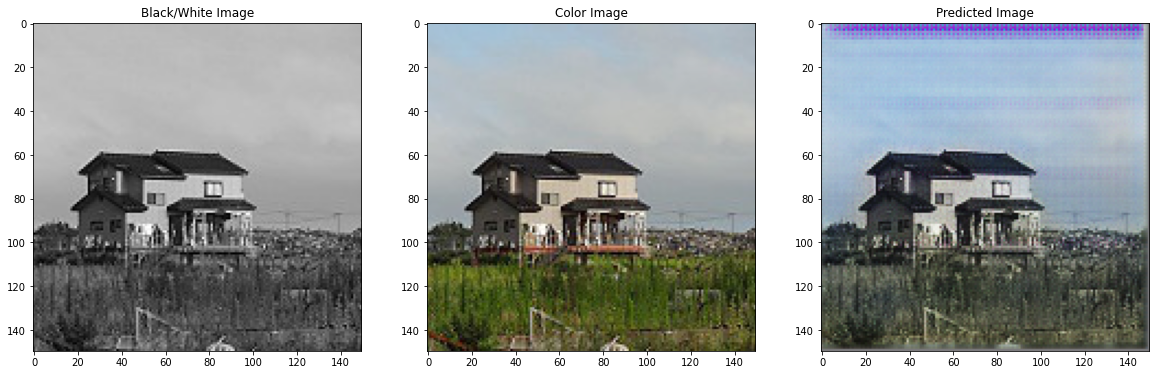

100%|██████████| 1425/1425 [11:05<00:00,  2.14it/s]


>13, d_loss_real[-0.804] d_loss_generated[0.373] gen_loss[24.049]


100%|██████████| 1425/1425 [11:02<00:00,  2.15it/s]


>14, d_loss_real[-0.851] d_loss_generated[0.398] gen_loss[1.805]


100%|██████████| 1425/1425 [11:00<00:00,  2.16it/s]


>15, d_loss_real[-0.898] d_loss_generated[0.424] gen_loss[4.633]


100%|██████████| 1425/1425 [11:01<00:00,  2.15it/s]


>16, d_loss_real[-0.945] d_loss_generated[0.449] gen_loss[0.999]


100%|██████████| 1425/1425 [11:03<00:00,  2.15it/s]


>17, d_loss_real[-0.992] d_loss_generated[0.475] gen_loss[2.790]


100%|██████████| 1425/1425 [11:02<00:00,  2.15it/s]


>18, d_loss_real[-1.038] d_loss_generated[0.500] gen_loss[2.953]


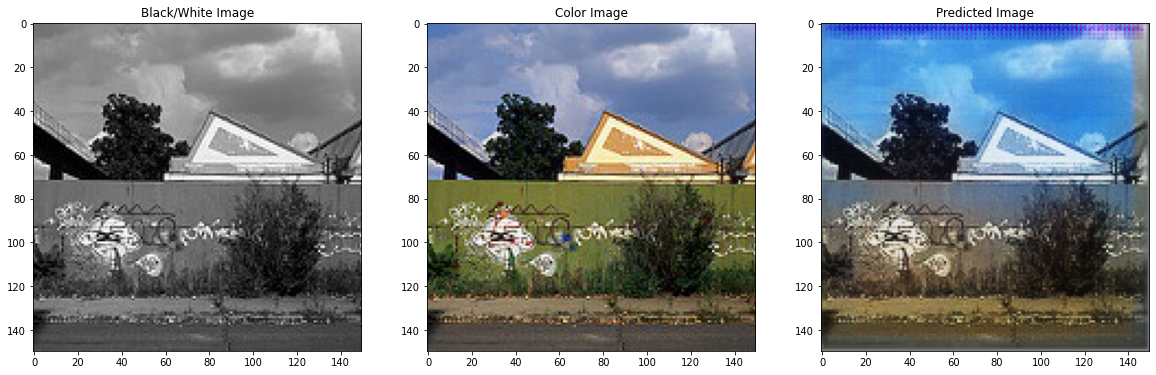

100%|██████████| 1425/1425 [11:03<00:00,  2.15it/s]


>19, d_loss_real[-1.085] d_loss_generated[0.526] gen_loss[0.839]


100%|██████████| 1425/1425 [11:09<00:00,  2.13it/s]


>20, d_loss_real[-1.132] d_loss_generated[0.551] gen_loss[1.050]


100%|██████████| 1425/1425 [11:08<00:00,  2.13it/s]


>21, d_loss_real[-1.178] d_loss_generated[0.577] gen_loss[0.568]


 21%|██        | 302/1425 [03:15<11:00,  1.70it/s]

In [ ]:
history = pix2pix_train(discriminator, generator, gen_update_model,trainA= bw_train,
                        trainB=c_train,n_epochs=25, n_batch=4)

# The predictions below are for the test sets
# Here d_real_loss should decrease while d_generated_loss should increase